In [1]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import kgof.density as density
import kgof.data as data

MCMCKernel = RandomWalkMH # RandomWalkBarker 

In [2]:
n = 1000
dim = 50
dh = 3
sigma = 0.
b_loc_on = tf.zeros(dim)
# b_loc_off = tf.constant([10., -10., 5.] + [0.] * (dim - 3))
b_loc_off = b_loc_on

c_loc_on = tf.zeros(dh)
c_loc_off = tf.concat([tf.ones(2) * 1., tf.zeros(dh-2)], axis=0)
# c_loc_off = tf.constant([1.])

# c_loc_on = tf.zeros(dh)
# c_loc_off = tf.zeros(dh)
seed = 0

2022-03-29 16:56:19.358155: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-29 16:56:19.358198: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-03-29 16:56:19.358203: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-03-29 16:56:19.358361: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-03-29 16:56:19.358382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-03-29 16:56:19.358387: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-03-29 16:56:19.359327: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

In [51]:
# off_target, log_prob_off_fn = models.create_rbm(c=c_loc_off, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)
# target, log_prob_fn = models.create_rbm(c=c_loc_on, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)

B_scale = 10.
off_target, log_prob_off_fn, ds_off = models.create_rbm(B_scale=B_scale, c=c_loc_off, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)
target, log_prob_fn, ds_on = models.create_rbm(B_scale=B_scale, c=c_loc_on, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)

In [52]:
# off_samples, off_mean, off_ratio = off_target.sample(n)
# on_samples, on_mean, on_ratio = target.sample(n)

off_samples = off_target.sample(n)
on_samples = target.sample(n)

In [53]:
# xx = ds_on.X[::100, 0, 0]
# xx2 = ds_on.X[2000:, 0, 0]
# xx3 = tf.random.normal((100,))

# plt.figure(figsize=(10, 3))
# plt.subplot(1, 3, 1)
# plt.scatter(range(20), tfp.stats.auto_correlation(xx)[:20])
# plt.ylim(-0.5, 1.05)
# plt.subplot(1, 3, 2)
# plt.scatter(range(20), tfp.stats.auto_correlation(xx2)[:20])
# plt.ylim(-0.5, 1.05)
# plt.subplot(1, 3, 3)
# plt.scatter(range(20), tfp.stats.auto_correlation(xx3)[:20])
# plt.ylim(-0.5, 1.05)

# # xx = ds_on.X[:20, 0, 0]
# # xx2 = ds_on.X[5000:, 0, 0]
# # xx3 = tf.random.normal((100,))

# plt.figure(figsize=(10, 3))
# plt.subplot(1, 3, 1)
# _ = plt.acorr(xx, maxlags = 10)
# plt.subplot(1, 3, 2)
# _ = plt.acorr(xx2, maxlags = 10)
# plt.subplot(1, 3, 3)
# _ = plt.acorr(xx3, maxlags = 10)

# import scipy.stats as stats
# import pylab 
# stats.probplot(xx, dist="norm", plot=pylab)

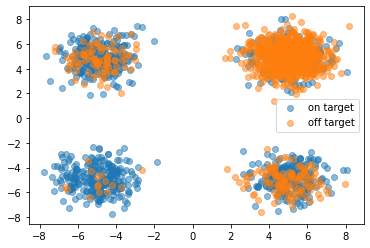

In [54]:
plt.scatter(on_samples[:, 0], on_samples[:, 1], label="on target", alpha=0.5)
plt.scatter(off_samples[:, 0], off_samples[:, 1], label="off target", alpha=0.5)
_ = plt.legend()

In [55]:
# ## theoretical and empirical proportions
# ## when dh = 2
# r1 = np.exp(np.sqrt(100*dim)/8 + 2.*dh)
# r2 = np.exp(np.sqrt(100*dim)/8)
# r3 = np.exp(np.sqrt(100*dim)/8 - 2.*dh)
# rsum = r1 + r2*2 + r3
# print(r1/rsum, r2/rsum, r3/rsum)

xx = off_samples.numpy()
print(
    xx[(xx[:, 0] > 0.) & (xx[:, 1] > 0.), :].shape[0] / n,
    xx[(xx[:, 0] < 0.) & (xx[:, 1] > 0.), :].shape[0] / n,
    xx[(xx[:, 0] > 0.) & (xx[:, 1] < 0.), :].shape[0] / n,
    xx[(xx[:, 0] < 0.) & (xx[:, 1] < 0.), :].shape[0] / n
)
# print(
#     xx[(xx[:, 0] > 0.), :].shape[0] / n,
#     xx[(xx[:, 0] < 0.), :].shape[0] / n,
# )
# rr = ds_off.H[-1, :]
# print(
#     np.mean(rr[:, 0] == 1.),
#     np.mean(rr[:, 0] == -1.)
# )

0.767 0.096 0.122 0.015


In [56]:
B = tf.eye(tf.reduce_max((dim, dh)))[:dim, :dh] * B_scale
ll = []
for h in [[1., 1.], [-1., 1], [1., -1], [-1., -1.]]:
# for h in [[1.], [-1.]]:
    h = tf.reshape(tf.constant(h), (-1, 1))
    pp = tf.exp(0.5 * tf.reduce_sum((0.5 * B @ h)**2) + tf.reshape(c_loc_off, (1, -1)) @ h)
    ll.append(pp.numpy()[0, 0])
print([x / np.sum(ll) for x in ll])

[0.77580345, 0.104993574, 0.104993574, 0.014209335]


In [3]:
# def generate_rbm(c, dx, dh, n):
#     '''only works when dh == 1'''
#     B = tf.eye(tf.reduce_max((dx, dh)))[:dx, :dh] * 10. # dx x dh
#     b = tf.zeros(dx)

#     h_list = tf.constant([[1.], [-1.]])
#     gamma_list = []
#     for i in range(h_list.shape[0]):
#         h = h_list[i, :]
#         gamma = tf.exp(c*h) # assuming B = I[:dx, :dh]
#         gamma_list.append(gamma)
#     gamma_list = [x / sum(gamma_list) for x in gamma_list]
    
#     u = tf.random.uniform((n, dh))
#     H = tf.cast(u <= gamma_list[0], dtype=tf.float32) * 2. - 1. # n x dh
    
#     mean = 0.5 * H @ tf.transpose(B) + b # n x dx
#     X = tf.random.normal((n, dx)) + mean # n x dx
#     return X

def generate_rbm(c, dx, dh, B_scale):
    dist, log_prob_off_fn, ds = models.create_rbm(B_scale=1., c=c, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)
    _ = dist.sample(n)
    H = ds.H[-1, :]
    
    B = tf.eye(tf.reduce_max((dx, dh)))[:dx, :dh] * B_scale # dx x dh
    b = tf.zeros(dx)

    mean = 0.5 * H @ tf.transpose(B) + b # n x dx
    X = tf.random.normal((n, dx)) + mean # n x dx
    return X

In [10]:
plt.scatter(on_samples[:, 0], on_samples[:, 1], label="on target", alpha=0.5)
plt.scatter(xx[:, 0], xx[:, 1], label="off target", alpha=0.5)
_ = plt.legend()

In [4]:
def repeat_experiment(nrep, B_scale):    
    off_target2, log_prob_off_fn2 = models.create_rbm(
        B_scale=B_scale, c=c_loc_off, dx=dim, dh=dh, return_logprob=True, burnin_number=2000)

    num_boot = 800
    alpha = 0.05

    kernel = IMQ(med_heuristic=True)
    ksd = KSD(target=off_target2, kernel=kernel)
    bootstrap = Bootstrap(ksd, n)
    
    multinom_samples = bootstrap.multinom.sample((nrep, num_boot))
    multinom_one_sample = multinom_samples[0, :]
    
    p_val_list = []
    for i in trange(nrep):
        off_sample2 = off_target2.sample(n)
#         syn_sample = generate_rbm(c=c_loc_off, dx=dim, dh=dh, B_scale=B_scale)
        syn_sample = off_sample2 #!
    
        kernel = IMQ(med_heuristic=True)
        ksd = KSD(target=off_target2, kernel=kernel)
        bootstrap = Bootstrap(ksd, n)
        
        multinom_one_sample = multinom_samples[i, :]
        
        _, p_val2 = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=off_sample2, multinom_samples=multinom_one_sample)
        _, p_val_sync = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=syn_sample, multinom_samples=multinom_one_sample)

        p_val_list.append((p_val2, "builtin"))
        p_val_list.append((p_val_sync, "synthetic"))
        
    res = pd.DataFrame(p_val_list, columns=["pval", "type"])
    return res

In [6]:
tf.random.set_seed(0)

nrep = 100
res = repeat_experiment(nrep, B_scale=10.)
# res2 = repeat_experiment(nrep, B_scale=5.)

<AxesSubplot:xlabel='pval', ylabel='Proportion'>

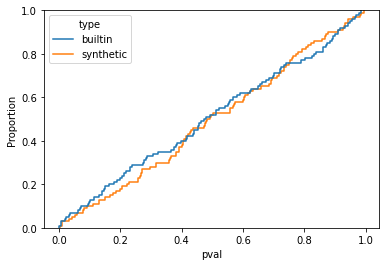

In [15]:
sns.ecdfplot(data=res, x="pval", hue="type")

<AxesSubplot:xlabel='pval', ylabel='Proportion'>

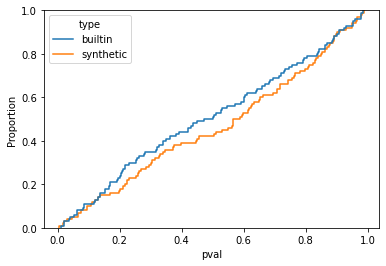

In [12]:
sns.ecdfplot(data=res2, x="pval", hue="type")

# p-value

In [72]:
ntrain = n // 2
sample_init = on_samples
sample_init_train, sample_init_test = sample_init[:ntrain, ], sample_init[ntrain:, ]
start_pts = sample_init_train # [69:70, ] + tf.constant([[0., 0.]])
# start_pts

In [73]:
grad_log = None # target.grad_log
mode_list, inv_hess_list = find_modes(start_pts, log_prob_fn, grad_log=grad_log, threshold=1.)

In [16]:
_, ind_pair_list = pairwise_directions(mode_list, return_index=True)

In [17]:
mode_list

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5., -5.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-5.,  5.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 5., -5.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5., 5.], dtype=float32)>]

In [18]:
std_ls = np.linspace(0.5, 1.5, 21).tolist() # std for discrete jump proposal
MCMCKernel = RandomWalkMH
ksd = KSD(target=target, kernel=IMQ(med_heuristic=True))
T = 2

best_ksd = 0.
for j in trange(len(ind_pair_list)):
    # loop through mode pairs

    # find estimated hessians
    ind1, ind2 = ind_pair_list[j]
    mode1, mode2 = mode_list[ind1], mode_list[ind2]
    hess1_inv, hess2_inv = inv_hess_list[ind1], inv_hess_list[ind2]

    proposal_dict = mcmc.prepare_proposal_input(
        mode1=mode1, mode2=mode2, hess1_inv=hess1_inv, hess2_inv=hess2_inv)

    for i, std in enumerate(std_ls):
        # run dynamic for T steps
        mh = MCMCKernel(log_prob=log_prob_fn)
        mh.run(steps=T, std=std, x_init=sample_init_train, **proposal_dict)

        # compute ksd
        x_t = mh.x[-1, :, :].numpy()
        _, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
        ksd_val = ksd_val.numpy()

        # update if ksd is larger
        if (ksd_val > best_ksd) or (i == 0):
            best_std = std
            best_ksd = ksd_val
            best_proposal_dict = proposal_dict


  0%|          | 0/6 [00:00<?, ?it/s]

2022-03-09 21:32:56.271592: I tensorflow/core/util/cuda_solvers.cc:180] Creating CudaSolver handles for stream 0x81d15f0


In [19]:
# best modes: 
# mode1 = [-47.72526,  -5.90596]
# mode2 = [-10.433735,  45.227673]
# best std: 1.5
best_proposal_dict

{'mode1': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 5., -5.], dtype=float32)>,
 'hess1_sqrt': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 0.],
        [0., 1.]], dtype=float32)>,
 'hess1_inv_sqrt': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 0.],
        [0., 1.]], dtype=float32)>,
 'hess1_sqrt_det': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'hess1_inv_sqrt_det': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'mode2': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([5., 5.], dtype=float32)>,
 'hess2_sqrt': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 0.],
        [0., 1.]], dtype=float32)>,
 'hess2_inv_sqrt': <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1., 0.],
        [0., 1.]], dtype=float32)>,
 'hess2_sqrt_det': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'hess2_inv_sqrt_det': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>}

In [21]:
mh = MCMCKernel(log_prob=log_prob_fn)
mh.run(steps=T, std=best_std, x_init=sample_init_train, **proposal_dict)

# compute ksd
x_t = mh.x[-1, :, :].numpy()
_, ksd_val = ksd.h1_var(X=x_t, Y=tf.identity(x_t), return_scaled_ksd=True)
ksd_val = ksd_val.numpy()

In [22]:
nrep = 1
num_boot = 800
alpha = 0.05

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=target, kernel=kernel)
bootstrap = Bootstrap(ksd, x_t.shape[0])

In [23]:
multinom_samples = bootstrap.multinom.sample((nrep, num_boot))

multinom_one_sample = multinom_samples[0, :]

2022-03-09 21:35:25.344466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [25]:
_, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
p_val

0.5617977528089888

In [ ]:
def repeat_experiment(multinom_samples, 
                      bootstrap, 
                      alpha, 
                      num_boot,
                      x_t):
    
    p_val_list = []
    for r in trange(multinom_samples.shape[0]):
        multinom_one_sample = multinom_samples[r, :, :]
        _, p_val = bootstrap.test_once(alpha=alpha, num_boot=num_boot, X=x_t, multinom_samples=multinom_one_sample)
        p_val_list.append(p_val)
        
    return p_val_list


In [ ]:
p_val_list = repeat_experiment(
    multinom_samples, 
    bootstrap, 
    alpha, 
    num_boot,
    x_t)

In [ ]:
p_val_df = pd.DataFrame({"p_val": p_val_list})
sns.ecdfplot(data=p_val_df)
plt.axis(xmin=-0.01, xmax=1., ymin=0, ymax=1.01)